In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Submissions are evaluated on area under the ROC curve between 
the predicted probability and the observed target.
-예측된 확률과 관측된 목표 사이의 ROC 커브 곡선 아래 영역 평가

In [2]:
train = pd.read_csv('./play/train.csv')
test = pd.read_csv('./play/test.csv')
result_list = []

In [20]:
train.id.drop_duplicates()

0              0
1              1
2              2
3              3
4              4
           ...  
101758    101758
101759    101759
101760    101760
101761    101761
101762    101762
Name: id, Length: 101763, dtype: int64

EDA
1. No Na, no duplicates
2. Target imbalance : True 22.66 / False 77.34
3. right-skewed, nonnegative -> log-transformation recommended

In [4]:
# https://www.kaggle.com/code/kimtaehun/eda-and-baseline-with-multiple-models
def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
    # Set background color
    
    f, ax = plt.subplots(1, 2, figsize=(16, 7))
    plt.subplots_adjust(wspace=0.2)

    s1 = df[col].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = ['#59b3a3', '#433C64']
    inner_colors = ['#59b3a3', '#433C64']
    #['#ff6905', '#ff8838', '#ffa66b']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90, frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold', 'color': 'white'}
    )

    textprops = {
        'size': 13, 
        'weight': 'bold', 
        'color': 'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', fc='#243139', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = s1.index.tolist()
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette='mako', orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,       
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i+0.1, str(v), color='white', fontweight='bold', fontsize=12)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col, fontweight="bold", color='white')
    ax[1].set_ylabel('count', fontweight="bold", color='white')

    f.suptitle(f'{title_name}', fontsize=14, fontweight='bold', color='white')
    plt.tight_layout() 
    plt.show()

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype

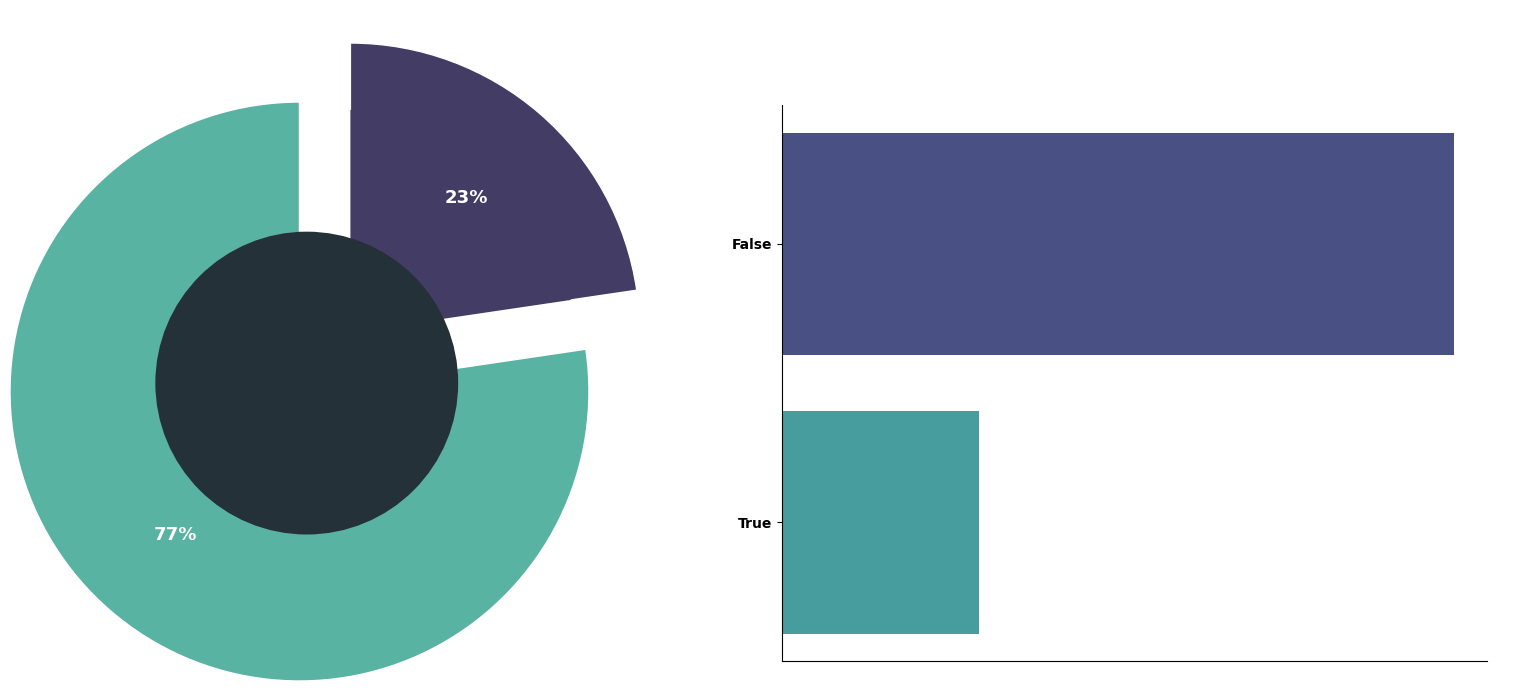

In [6]:
plot_count(train, 'defects', 'Target Variable Distribution')

# 전처리

In [35]:
Xtrain = train.drop(columns = ['defects'])
ytrain = train.defects.astype(int).reset_index().drop(columns=['index'])
Xtest = test.copy()
for col in Xtrain.columns:
    Xtrain[col] = Xtrain[col].apply(lambda x: np.log(x) if x > 0 else 0)
    Xtest[col] = Xtest[col].apply(lambda x: np.log(x) if x > 0 else 0)
print(Xtrain.shape, ytrain.shape, Xtest.shape)
    

(101763, 22) (101763, 1) (67842, 22)


In [34]:
display(ytrain)
display(train.defects)

,index,defects
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
101758,101758,0
101759,101759,0
101760,101760,0
101761,101761,0


0         False
1         False
2         False
3          True
4         False
          ...  
101758    False
101759    False
101760    False
101761    False
101762    False
Name: defects, Length: 101763, dtype: bool

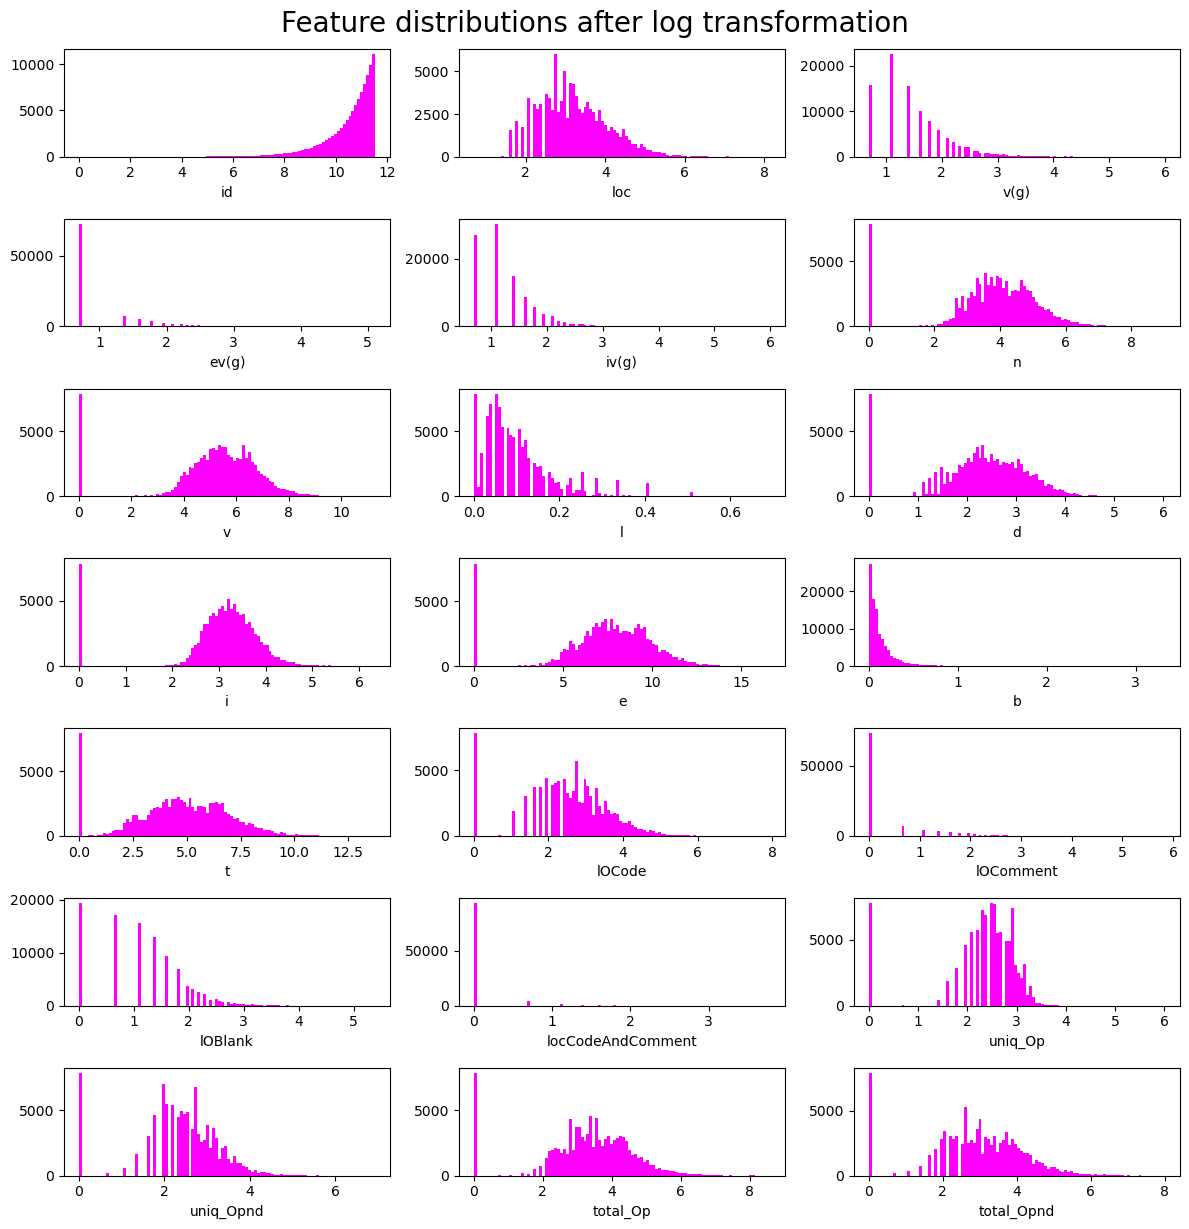

In [25]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()):
    ax.hist(np.log1p(train[col]), bins=100, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

In [26]:
def cross_val(model, label):
    """Cross-validate the model with a StratifiedKFold
    
    The cross-validation score is printed and added to the global result_list"""
    start_time = datetime.now()
    kf = StratifiedKFold(shuffle=True, random_state=1)
    oof = np.full(len(train), np.nan)
    auc_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.defects)):
        X_tr = train.iloc[idx_tr]
        X_va = train.iloc[idx_va]
        y_tr = X_tr.pop('defects')
        y_va = X_va.pop('defects')
        model.fit(X_tr, y_tr)
#         print(np.round(model[-1].coef_, 2), np.round(model[-1].intercept_, 2))
        try:
            y_va_pred = model.predict_proba(X_va)[:, 1]
        except AttributeError: # 'LinearSVC' object has no attribute 'predict_proba'
            y_va_pred = model.decision_function(X_va)
        oof[idx_va] = y_va_pred
        auc = roc_auc_score(y_va, y_va_pred)
        auc_list.append(auc)
    auc = np.array(auc_list).mean()
    execution_time = datetime.now() - start_time
    print(f"# AUC {auc:.5f}   time={str(execution_time)[-15:-7]}   {label}")
    result_list.append((auc, label, execution_time))
#     plt.figure(figsize=(6, 2))
#     plt.hist(oof, bins=200, density=True)
#     plt.show()
    return auc

In [ ]:
def plot_score_list(label, parameter, xscale='linear'):
    """Show a scatterplot of the scores in the global variable score_list"""
    plt.figure(figsize=(6, 3))
    plt.scatter([p for p, s in score_list],
                [s for p, s in score_list])
    plt.xscale(xscale)
    plt.xlabel(f'{parameter}{" (log-scale)" if xscale == "log" else ""}')
    plt.ylabel('AUC score')
    plt.title(label)
    plt.show()

In [23]:
train.defects.value_counts()

defects
False    78699
True     23064
Name: count, dtype: int64

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

%      1. loc             : numeric % McCabe's line count of code
%      2. v(g)            : numeric % McCabe "cyclomatic complexity"
%      3. ev(g)           : numeric % McCabe "essential complexity"
%      4. iv(g)           : numeric % McCabe "design complexity"
%      5. n               : numeric % Halstead total operators + operands
%      6. v               : numeric % Halstead "volume"
%      7. l               : numeric % Halstead "program length"
%      8. d               : numeric % Halstead "difficulty"
%      9. i               : numeric % Halstead "intelligence"
%     10. e               : numeric % Halstead "effort"
%     11. b               : numeric % Halstead 
%     12. t               : numeric % Halstead's time estimator
%     13. lOCode          : numeric % Halstead's line count
%     14. lOComment       : numeric % Halstead's count of lines of comments
%     15. lOBlank         : numeric % Halstead's count of blank lines
%     16. lOCodeAndComment: numeric
%     17. uniq_Op         : numeric % unique operators
%     18. uniq_Opnd       : numeric % unique operands
%     19. total_Op        : numeric % total operators
%     20. total_Opnd      : numeric % total operands
%     21: branchCount     : numeric % of the flow graph
%     22. defects         : {false,true} % module has/has not one or more 
%                                        % reported defects

사용 모델:
RandomForestClassifier
ExtraTreesClassifier
HistGradientBoostingClassifier
XGBClassifier
LGBMClassifier
CatBoostClassifier
one non-tree model 
(the best one you can find), for instance a kernel approximation classifier

교차 검증:
StratifiedKFold 또는 RepeatedStratifiedKFold

Nyström kernel approximation

HistGradientboostClassfier
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)

result = permutation_importance(hgb, test_input, test_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)

hgb.score(test_input, test_target)